Plot the significance threshold for PD(V1) in the experimental visual data. 

Significance threshold is computed using the topological bootstrapping method.

* The significance threshold is computed using R (`PD_confidence_sets.Rmd`)
* This notebook uses Python.

In [ ]:
import pandas as pd
import numpy as np
import pickle as pickle
import gudhi as gd  
import seaborn as sbs
from scipy.spatial import distance_matrix
from pylab import *

In [2]:
# from https://github.com/GUDHI/TDA-tutorial/blob/master/persistence_statistics.py

def hausd_interval(data, level = 0.95, m=-1, B =1000,pairwise_dist = False,
                   leaf_size = 2,ncores = None):
    
    '''
    Subsampling Confidence Interval for the Hausdorff Distance between a 
    Manifold and a Sample
    Fasy et al AOS 2014
    
    Input:
    data : a nxd numpy array representing n points in R^d, or a nxn matrix of pairwise distances
    m : size of each subsample. If m=-1 then m = n / np.log(n)   
    B : number of subsamples 
    level : confidence level
    pairwise_dist : if pairwise_dist = True then data is a nxn matrix of pairwise distances
    leaf_size : leaf size for KDTree
    ncores :  number of cores for multiprocessing (if None then the maximum number of cores is used)
        
    Output: 
    quantile for the Hausdorff distance
        
   
    '''
    
    
    import numpy as np
    from multiprocessing import Pool
    from sklearn.neighbors import KDTree


    
    # sample size
    n = np.size(data,0)
    
    # subsample size
    if m == -1:
        m = int (n / np.log(n))
    
    
    # Data is an array
    if pairwise_dist == False:
            
        # for subsampling
        # a reprendre sans shuffle slit   

        
        global hauss_dist
        def hauss_dist(m):
            '''
            Distances between the points of data and a random subsample of data of size m
            '''            
            I = np.random.choice(n,m)
            Icomp = [item for item in np.arange(n) if item not in I]
            tree = KDTree(data[I,],leaf_size=leaf_size)
            dist, ind = tree.query(data[Icomp,],k=1) 
            hdist = max(dist)
            return(hdist)
        
        # parrallel computing
        with Pool(ncores) as p:
            dist_vec = p.map(hauss_dist,[m]*B)
        p.close()
        dist_vec = [a[0] for a in dist_vec]        
          
        
    # Data is a matrix of pairwise distances    
    else:
        def hauss_dist(m):
            '''
            Distances between the points of data and a random subsample of data of size m
            '''
            I = np.random.choice(n,m)    
            hdist= np.max([np.min(data[I,j]) for j in np.arange(n) if j not in I])              
            return(hdist)
            
        # parrallel computing
        with Pool(ncores) as p:
            dist_vec = p.map(hauss_dist, [m]*B)
        p.close()
    
            
    # quantile and confidence band
    myquantile = np.quantile(dist_vec, level)
    c = 2 * myquantile     
            
    return(c)




def truncated_simplex_tree(st,int_trunc=100):
    '''
    This function return a truncated simplex tree 
    
    Input:
    st : a simplex tree
    int_trunc : number of persistent interval keept per dimension (the largest)
    
    Ouptut:
    st_trunc_pers : truncated simplex tree    
    '''
    
    st.persistence()    
    dim = st.dimension()
    st_trunc_pers = [];
    for d in range(dim):
        pers_d = st.persistence_intervals_in_dimension(d)
        d_l= len(pers_d)
        if d_l > int_trunc:
            pers_d_trunc = [pers_d[i] for i in range(d_l-int_trunc,d_l)]
        else:
            pers_d_trunc = pers_d
        st_trunc_pers = st_trunc_pers + [(d,(l[0],l[1])) for l in pers_d_trunc]
    return(st_trunc_pers)

# Confidence set from subsampling approach
* From Fasy et al 2014 Annals of Statistics paper.
* As the authors mention, this confidence set is very conservative.

In [5]:
# load distance
total_distance = np.loadtxt("../../../analysis/experimental_visual/data/total_dissimilarity.csv")
D_V1 = total_distance[0:53, 0:53]
D_AL = total_distance[53:94, 53:94]
print("Shape of D_V1: ", D_V1.shape)
print("Shape of D_AL: ", D_AL.shape)

Shape of D_V1:  (53, 53)
Shape of D_AL:  (41, 41)


usetex mode requires TeX.


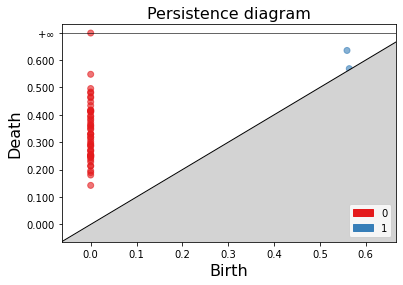

In [11]:
# compute persistence
skeleton = gd.RipsComplex(distance_matrix = D_V1,max_edge_length=2) 
Rips_simplex_tree_trefoil = skeleton.create_simplex_tree(max_dimension=2)
BarCodes = Rips_simplex_tree_trefoil.persistence()
gd.plot_persistence_diagram(BarCodes);

In [35]:
hatc = hausd_interval(D_V1,pairwise_dist=True,level = 0.95, m = 53)
print(hatc)

1.2148203594441234


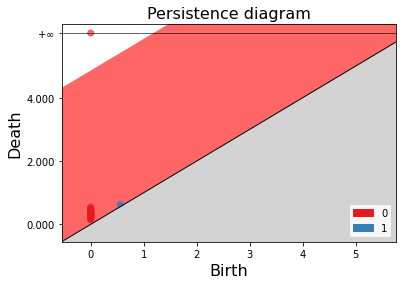

In [36]:
gd.plot_persistence_diagram(BarCodes, band = 4 * hatc);

# A more precise confidence set can be found.
* See R code "PD_confidence_sets.md"
* threshold, for V1, according to bootstrapping: 0.1428
* threshold, for AL, according to bootstrapping: 0.0622

In [16]:
import sys
sys.path.insert(0, '../../src/')

In [17]:
from plotting import *

In [20]:
barcode_V1 = np.array([[0.563936, 0.568567], [0.558992, 0.634908]])
barcode_AL = np.array([[0.381433, 0.386574], [0.456083, 0.508385]])

<AxesSubplot:>

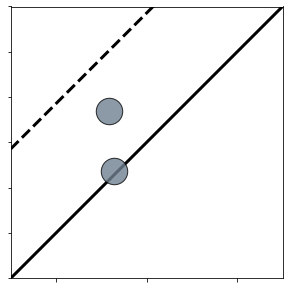

In [29]:
highlight_color = "#f72585"
size_significant = 700
size_noise = 700
titlefontsize = 20
tickfontsize = 20
pd_min = 0.45
pd_max = 0.75

fig, ax = plt.subplots(figsize = (5, 5))
plot_PD(barcode_V1, 
        ax = ax, 
#        title = "PD(V1, dim 1)", 
        titlefontsize = titlefontsize,
        alpha = 0.8,
        s = size_noise, 
        pd_min = pd_min, 
        pd_max = pd_max,
        marker = "o",
        edgecolor = "black",
        threshold = 0.1428, 
        tickfontsize = tickfontsize)